In [7]:
# definitions for pre-processing data
import pandas as pd
import datetime 
import numpy as np

def convert_time(string_time):
    # given a time in string format, output a time in datetime.time format
    format = "%H:%M:%S"
    output = datetime.datetime.strptime(string_time, format)
    return output.time()

def convert_date(string_date):
    # given a date in string format, output a time in datetime.date format
    format = "%m/%d/%Y"
    output = datetime.datetime.strptime(string_date, format)
    return output.date()

def calculate_volatility(df):
    # given a df for a time period, calculate the VWAP for this time period
    volume_total = df["Volume"].sum()
    volume_times_price_total = (df["Volume"] * df["Price"]).sum()
    vwap = volume_times_price_total / volume_total
    last_valid_index = df["Price"].last_valid_index()
    final_price = df["Price"][last_valid_index]
    volatility = abs(final_price - vwap)
    volatility = volatility / final_price * 100
    return volatility

def gen_features_and_targets(df):
    grouped_by_date = df.groupby(df['Date'])
    features = []
    targets = []
    for date in grouped_by_date.groups.keys():
        cur_df = grouped_by_date.get_group(date)
        cur_grouped = cur_df.groupby(cur_df["Minute"])
        cur_features = []
        for minute in range(30, 60):
            try:
                cur_minute = cur_grouped.get_group(minute)
            except:
                if minute == 59:
                    targets.append(0)
                else:
                    cur_features.append(0)
                continue
            volatility = calculate_volatility(cur_minute)
            if minute == 59:
                targets.append(volatility)
            else:
                cur_features.append(volatility)
        features.append(cur_features)
    return np.array(features), np.array(targets)

def main_load_data(path):
    df = pd.read_csv(path)
    df['Time'] = df['Time'].apply(lambda x: convert_time(x))
    df = df.loc[(df['Time'] >= datetime.time(14, 30, 0)) & (df["Time"] < datetime.time(15, 0, 0))]
    df['Date'] = df['Date'].apply(lambda x: convert_date(x))
    df['Minute'] = df['Time'].apply(lambda x: x.minute)
    features, targets = gen_features_and_targets(df)
    return features, targets

In [8]:
features, targets = main_load_data("IVE_tickbidask.txt")

In [16]:
# definitions for the base model
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

activation_relu = torch.nn.ReLU()
Loss_Function = torch.nn.MSELoss()
Learning_Rate = 0.00001


class BaseModule(torch.nn.Module):
    def __init__(self):
        super(BaseModule, self).__init__()
        self.layer_1 = torch.nn.Linear(29, 10)
        self.layer_2 = torch.nn.Linear(10, 1)
    
    def forward(self, x):
        x = self.layer_1(x)
        x = activation_relu(x)
        x = self.layer_2(x)
        return x
    
    
def train_model(dataset, model, epochs):
    #for epoch in tqdm(range(epochs)):
    for epoch in range(epochs):
        for data in dataset:
            x, y = data
            optimizer.zero_grad()
            output = model(x)
            y = torch.Tensor([y])
            print(y)
            #print("Output = {}".format(output))
            #print("y = {}".format(y))
            loss = Loss_Function(output, y)
            loss.backward()
            optimizer.step()
            
def test_model(dataset, model):
    loss_list = []
    for data in dataset:
        x, y = data
        output = model(x)
        y = torch.Tensor([y])
        loss = Loss_Function(output, y)
        loss_list.append(loss)
    return loss_list

def step_train_model(train_dataset, test_dataset, model):
    train_model(train_dataset, model, 1)
    loss = test_model(test_dataset, model)
    return loss[0]

In [23]:
import torch.nn as nn
import torch.optim as optim

# global constants --------------------------------------------------------------------------------
g_epoch = 10
g_activation_function = torch.nn.ReLU()
g_loss_function = torch.nn.MSELoss()
g_learning_rate = 0.01

# -------------------------------------------------------------------------------------------------

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = torch.nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3)
        self.maxpool_1 = torch.nn.MaxPool1d(kernel_size=3)
        self.fc_1 = torch.nn.Linear(9, 5)
        self.fc_2 = torch.nn.Linear(5, 1)
    
    def forward(self, x):
        x = x.view(1, 1, 29)
        x = self.maxpool_1(g_activation_function(self.conv_1(x)))
        x = x.view(9)
        x = self.fc_1(x)
        x = g_activation_function(x)
        x = self.fc_2(x)
        return x

    
def train_model(dataset, model, epoch):
    for e in range(epoch):
        for data in dataset:
            x, y = data
            optimizer.zero_grad()
            output = model(x)
            y = torch.Tensor([y])
            loss = g_loss_function(output, y)
            loss.backward()
            optimizer.step()
            
            
def test_model(dataset, model):
    loss_list = []
    for data in dataset:
        x, y = data
        output = model(x)
        y = torch.Tensor([y])
        loss = g_loss_function(output, y)
        loss_list.append(loss)
    return loss_list


def step_train_model(train_dataset, test_dataset, model):
    train_model(train_dataset, model, 1)
    loss = test_model(test_dataset, model)
    return loss[0]


net = Net()
optimizer = optim.SGD(net.parameters(), lr=g_learning_rate)

In [24]:
train_model(train_dataset, net, 2)
loss_list = test_model(train_dataset, net)
loss_list[0:10]


[tensor(0.0001, grad_fn=<MseLossBackward>),
 tensor(4.0314e-06, grad_fn=<MseLossBackward>),
 tensor(9.1506e-05, grad_fn=<MseLossBackward>),
 tensor(6.1005e-05, grad_fn=<MseLossBackward>),
 tensor(8.2055e-05, grad_fn=<MseLossBackward>),
 tensor(1.9388e-05, grad_fn=<MseLossBackward>),
 tensor(0.0011, grad_fn=<MseLossBackward>),
 tensor(6.4061e-05, grad_fn=<MseLossBackward>),
 tensor(0.0001, grad_fn=<MseLossBackward>),
 tensor(0.0001, grad_fn=<MseLossBackward>)]

In [4]:
net = BaseModule()
optimizer = optim.SGD(net.parameters(), lr=Learning_Rate)

In [10]:
tensor_features = torch.Tensor(features)
tensor_targets = torch.Tensor(targets)
my_dataset = TensorDataset(tensor_features, tensor_targets)
#train_dataset, test_dataset = torch.utils.data.random_split(my_dataset, [200, 49])
train_dataset, test_dataset = torch.utils.data.random_split(my_dataset, [2500, 285])

100%|██████████| 100/100 [05:06<00:00,  3.06s/it]


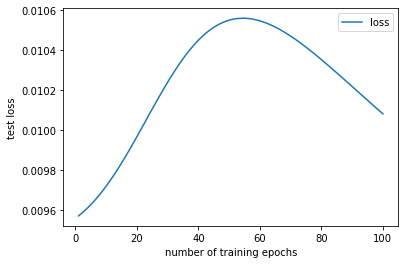

In [25]:
import matplotlib
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
%matplotlib inline

epoch = 100

fix, ax = plt.subplots()
x = []
y = []
current = 0
for i in tqdm(range(epoch)):
    current += 1
    x.append(current)
    y.append(math.sqrt(step_train_model(train_dataset, test_dataset, net)))
x = np.array(x)
y= np.array(y)


line_1 = ax.plot(x, y, label="loss")
ax.set(xlabel="number of training epochs", ylabel="test loss")
ax.legend()
plt.show()

100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


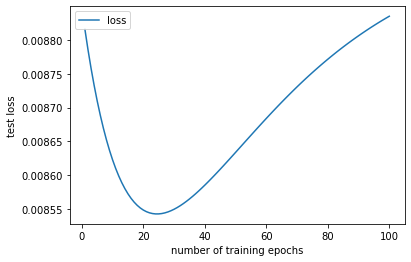

In [42]:
import matplotlib
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
%matplotlib inline

epoch = 100

fix, ax = plt.subplots()
x = []
y = []
current = 0
for i in tqdm(range(epoch)):
    current += 1
    x.append(current)
    y.append(math.sqrt(step_train_model(train_dataset, test_dataset, net)))
x = np.array(x)
y= np.array(y)


line_1 = ax.plot(x, y, label="loss")
ax.set(xlabel="number of training epochs", ylabel="test loss")
ax.legend()
plt.show()

In [43]:
features, targets = main_load_data("2019.txt")

In [44]:
net = BaseModule()
optimizer = optim.SGD(net.parameters(), lr=Learning_Rate)

In [45]:
tensor_features = torch.Tensor(features)
tensor_targets = torch.Tensor(targets)
my_dataset = TensorDataset(tensor_features, tensor_targets)
train_dataset, test_dataset = torch.utils.data.random_split(my_dataset, [200, 49])

100%|██████████| 1000/1000 [01:00<00:00, 16.50it/s]


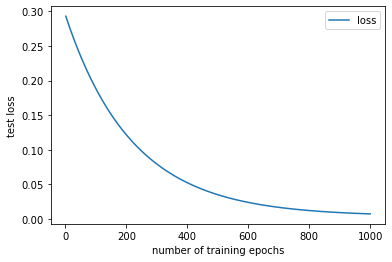

In [46]:
import matplotlib
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
%matplotlib inline

epoch = 1000

fix, ax = plt.subplots()
x = []
y = []
current = 0
for i in tqdm(range(epoch)):
    current += 1
    x.append(current)
    y.append(math.sqrt(step_train_model(train_dataset, test_dataset, net)))
x = np.array(x)
y= np.array(y)


line_1 = ax.plot(x, y, label="loss")
ax.set(xlabel="number of training epochs", ylabel="test loss")
ax.legend()
plt.show()